<a href="https://colab.research.google.com/github/bhuvnk/EVA6/blob/main/Session%206%20Batch%20Normalization%20and%20Regularization/Session_06_Normalization_Assignment_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Jun 11 22:12:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torchsummary import summary

%matplotlib inline
import matplotlib.pyplot as plt
import pickle

## YetAnotherDeepLearning Library

In [3]:
!git clone https://github.com/bhuvnk/EVA6.git
%cd "EVA6/Session 6 Batch Normalization and Regularization"
!pwd

fatal: destination path 'EVA6' already exists and is not an empty directory.
/content/EVA6/Session 6 Batch Normalization and Regularization
/content/EVA6/Session 6 Batch Normalization and Regularization


In [4]:
## Importing stuff from YetAnotherDeepLearning Library
from yadl.data import get_dataloaders
from yadl.model import Net
from yadl.train import train, get_optimizer
from yadl.test import test
from yadl.utils import get_misclassified, plot_single, plot_multi

## Trainer

In [5]:
EPOCHS = 20

SEED = 69
use_cuda = torch.cuda.is_available()

torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")

In [6]:
def train_model(name, bn=False, gn=False, ln=False, l1=False, l2=False, MAX_LR = 0.15):
  train_losses = []
  test_losses = []
  train_acc = []
  test_accs = []

  model =  Net(use_batchnorm=bn, use_groupnorm=gn, use_layernorm=ln).to(device)
  train_loader, test_loader = get_dataloaders()

  print("*****A bit of Model Summary*****")
  summary(model, input_size=(1, 28, 28))

  wd = 0
  lambda_l1 = None

  if l1: lambda_l1 = 0.0001
  if l2: wd = 0.0001

  optimizer = get_optimizer(model.parameters(), lr=0.01, momentum=0.9, weight_decay=wd)

  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=MAX_LR,
                                                steps_per_epoch=len(train_loader),
                                                epochs=EPOCHS) 

  print("*****Training Start*****")
  for epoch in range(EPOCHS):
      print('EPOCH {} and Learning Rate {}: '.format(epoch+1, scheduler.get_last_lr()))
      train_epoch_losses, train_epoch_acc = train(model, device, train_loader, optimizer, scheduler, lambda_l1=lambda_l1)
      test_loss, test_acc = test(model, device, test_loader)
      train_losses.extend(train_epoch_losses)
      train_acc.extend(train_epoch_acc)
      test_losses.append(test_loss)
      test_accs.append(test_acc)

  torch.save(model.state_dict(), f"{name}.pth")

  plot_single(name, train_losses, train_acc, test_losses, test_accs)
  return model, train_losses, test_losses, train_acc, test_accs

# 1 Group Normalization

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/EVA6/Session 6 Batch Normalization and Regularization/yadl/model.py:94: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
  0%|          | 0/469 [00:00<?, ?it/s]

*****A bit of Model Summary*****
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
         GroupNorm-3            [-1, 8, 28, 28]              16
         Dropout2d-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,152
              ReLU-6           [-1, 16, 28, 28]               0
         GroupNorm-7           [-1, 16, 28, 28]              32
         Dropout2d-8           [-1, 16, 28, 28]               0
            Conv2d-9            [-1, 8, 28, 28]             128
             ReLU-10            [-1, 8, 28, 28]               0
        MaxPool2d-11            [-1, 8, 14, 14]               0
           Conv2d-12           [-1, 12, 12, 12]             864
             ReLU-13           [-1, 12, 12, 12]               0
      

Loss=0.2232069969177246 Batch_id=468 Accuracy=76.40: 100%|██████████| 469/469 [00:14<00:00, 31.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0886, Accuracy: 9736/10000 (97.36%)

EPOCH 2 and Learning Rate [0.015652872880710073]: 


Loss=0.08103186637163162 Batch_id=468 Accuracy=94.71: 100%|██████████| 469/469 [00:14<00:00, 31.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0538, Accuracy: 9840/10000 (98.40%)

EPOCH 3 and Learning Rate [0.0420232149991973]: 


Loss=0.09543453902006149 Batch_id=468 Accuracy=96.10: 100%|██████████| 469/469 [00:14<00:00, 31.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9864/10000 (98.64%)

EPOCH 4 and Learning Rate [0.07804020523627854]: 


Loss=0.11841122061014175 Batch_id=468 Accuracy=96.75: 100%|██████████| 469/469 [00:14<00:00, 31.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9893/10000 (98.93%)

EPOCH 5 and Learning Rate [0.11404641502794495]: 


Loss=0.03147249296307564 Batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:15<00:00, 31.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9904/10000 (99.04%)

EPOCH 6 and Learning Rate [0.14038730642877603]: 


Loss=0.06708621233701706 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:15<00:00, 31.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9914/10000 (99.14%)

EPOCH 7 and Learning Rate [0.14999999141525278]: 


Loss=0.044670384377241135 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:15<00:00, 31.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9922/10000 (99.22%)

EPOCH 8 and Learning Rate [0.148111607483796]: 


Loss=0.036680225282907486 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:15<00:00, 31.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9926/10000 (99.26%)

EPOCH 9 and Learning Rate [0.14255711730886836]: 


Loss=0.013281975872814655 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:15<00:00, 30.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9920/10000 (99.20%)

EPOCH 10 and Learning Rate [0.1336150462213718]: 


Loss=0.08116193115711212 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:15<00:00, 30.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9915/10000 (99.15%)

EPOCH 11 and Learning Rate [0.12173378700447057]: 


Loss=0.013527173548936844 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:15<00:00, 30.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9935/10000 (99.35%)

EPOCH 12 and Learning Rate [0.10750911560711793]: 


Loss=0.008148382417857647 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:15<00:00, 30.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9930/10000 (99.30%)

EPOCH 13 and Learning Rate [0.09165431645023216]: 


Loss=0.12549670040607452 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:15<00:00, 30.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9937/10000 (99.37%)

EPOCH 14 and Learning Rate [0.07496441536741524]: 


Loss=0.03789840638637543 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:15<00:00, 31.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9937/10000 (99.37%)

EPOCH 15 and Learning Rate [0.05827631368991733]: 


Loss=0.0307011678814888 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:15<00:00, 30.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9944/10000 (99.44%)

EPOCH 16 and Learning Rate [0.04242682251929212]: 


Loss=0.006071765441447496 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:15<00:00, 30.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9940/10000 (99.40%)

EPOCH 17 and Learning Rate [0.028210701524546317]: 


Loss=0.03998357430100441 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:15<00:00, 30.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9944/10000 (99.44%)

EPOCH 18 and Learning Rate [0.01634080637370809]: 


Loss=0.01715855859220028 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:15<00:00, 30.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9950/10000 (99.50%)

EPOCH 19 and Learning Rate [0.007412343174006172]: 


Loss=0.08279570192098618 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:15<00:00, 30.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9948/10000 (99.48%)

EPOCH 20 and Learning Rate [0.0018730223522891091]: 


Loss=0.041593533009290695 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:15<00:00, 30.28it/s]



Test set: Average loss: 0.0181, Accuracy: 9948/10000 (99.48%)



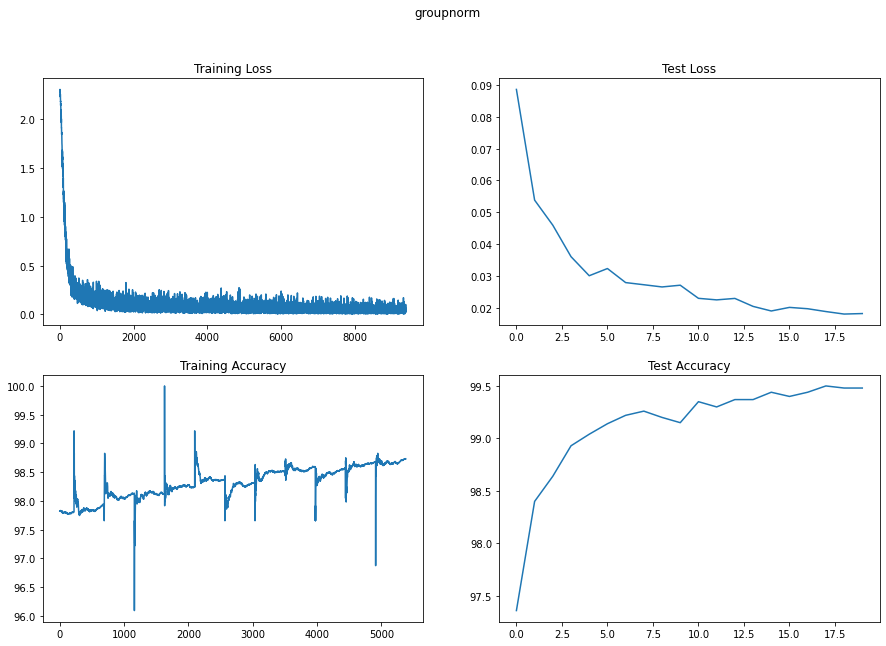

In [7]:
model, groupnorm_train_losses, groupnorm_test_losses, groupnorm_train_acc, groupnorm_test_acc = train_model("groupnorm", gn=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/EVA6/Session 6 Batch Normalization and Regularization/yadl/model.py:94: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


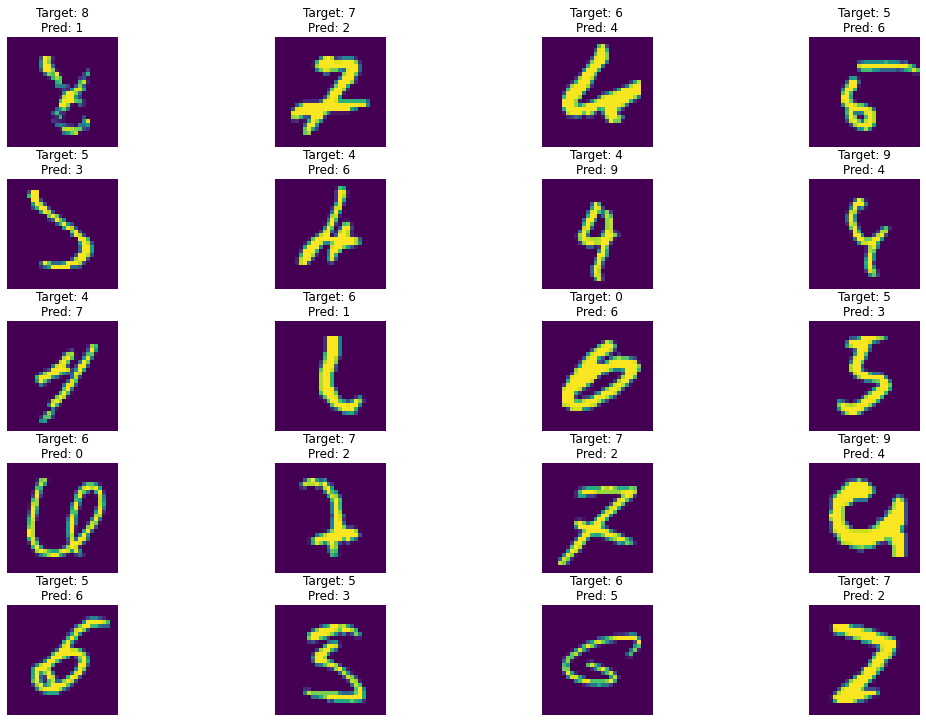

In [8]:
get_misclassified(model, "groupnorm")


# 2 Layer Normalization

In [9]:
del model

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/EVA6/Session 6 Batch Normalization and Regularization/yadl/model.py:94: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
  0%|          | 0/469 [00:00<?, ?it/s]

*****A bit of Model Summary*****
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
         GroupNorm-3            [-1, 8, 28, 28]              16
         Dropout2d-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,152
              ReLU-6           [-1, 16, 28, 28]               0
         GroupNorm-7           [-1, 16, 28, 28]              32
         Dropout2d-8           [-1, 16, 28, 28]               0
            Conv2d-9            [-1, 8, 28, 28]             128
             ReLU-10            [-1, 8, 28, 28]               0
        MaxPool2d-11            [-1, 8, 14, 14]               0
           Conv2d-12           [-1, 12, 12, 12]             864
             ReLU-13           [-1, 12, 12, 12]               0
      

Loss=0.22203315794467926 Batch_id=468 Accuracy=74.68: 100%|██████████| 469/469 [00:14<00:00, 31.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0987, Accuracy: 9700/10000 (97.00%)

EPOCH 2 and Learning Rate [0.015652872880710073]: 


Loss=0.055715251713991165 Batch_id=468 Accuracy=94.64: 100%|██████████| 469/469 [00:14<00:00, 31.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0595, Accuracy: 9821/10000 (98.21%)

EPOCH 3 and Learning Rate [0.0420232149991973]: 


Loss=0.06837692111730576 Batch_id=468 Accuracy=96.25: 100%|██████████| 469/469 [00:15<00:00, 30.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9868/10000 (98.68%)

EPOCH 4 and Learning Rate [0.07804020523627854]: 


Loss=0.15159516036510468 Batch_id=468 Accuracy=96.71: 100%|██████████| 469/469 [00:15<00:00, 31.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9913/10000 (99.13%)

EPOCH 5 and Learning Rate [0.11404641502794495]: 


Loss=0.035160940140485764 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:15<00:00, 31.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9900/10000 (99.00%)

EPOCH 6 and Learning Rate [0.14038730642877603]: 


Loss=0.05903591215610504 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:15<00:00, 30.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9895/10000 (98.95%)

EPOCH 7 and Learning Rate [0.14999999141525278]: 


Loss=0.08511435240507126 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:15<00:00, 30.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9886/10000 (98.86%)

EPOCH 8 and Learning Rate [0.148111607483796]: 


Loss=0.059538278728723526 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:15<00:00, 30.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9922/10000 (99.22%)

EPOCH 9 and Learning Rate [0.14255711730886836]: 


Loss=0.03170432522892952 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:15<00:00, 31.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9934/10000 (99.34%)

EPOCH 10 and Learning Rate [0.1336150462213718]: 


Loss=0.05897708237171173 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:15<00:00, 31.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9913/10000 (99.13%)

EPOCH 11 and Learning Rate [0.12173378700447057]: 


Loss=0.005258029326796532 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:15<00:00, 31.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9933/10000 (99.33%)

EPOCH 12 and Learning Rate [0.10750911560711793]: 


Loss=0.017577042803168297 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:15<00:00, 30.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9925/10000 (99.25%)

EPOCH 13 and Learning Rate [0.09165431645023216]: 


Loss=0.17978344857692719 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:15<00:00, 30.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9934/10000 (99.34%)

EPOCH 14 and Learning Rate [0.07496441536741524]: 


Loss=0.05451004207134247 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:15<00:00, 30.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9937/10000 (99.37%)

EPOCH 15 and Learning Rate [0.05827631368991733]: 


Loss=0.027291664853692055 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:15<00:00, 31.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9939/10000 (99.39%)

EPOCH 16 and Learning Rate [0.04242682251929212]: 


Loss=0.00911062303930521 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:14<00:00, 31.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9945/10000 (99.45%)

EPOCH 17 and Learning Rate [0.028210701524546317]: 


Loss=0.07591963559389114 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:14<00:00, 31.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9947/10000 (99.47%)

EPOCH 18 and Learning Rate [0.01634080637370809]: 


Loss=0.07070428878068924 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:14<00:00, 31.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9945/10000 (99.45%)

EPOCH 19 and Learning Rate [0.007412343174006172]: 


Loss=0.1593000888824463 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:15<00:00, 30.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9950/10000 (99.50%)

EPOCH 20 and Learning Rate [0.0018730223522891091]: 


Loss=0.05183421075344086 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:15<00:00, 30.22it/s]



Test set: Average loss: 0.0170, Accuracy: 9950/10000 (99.50%)



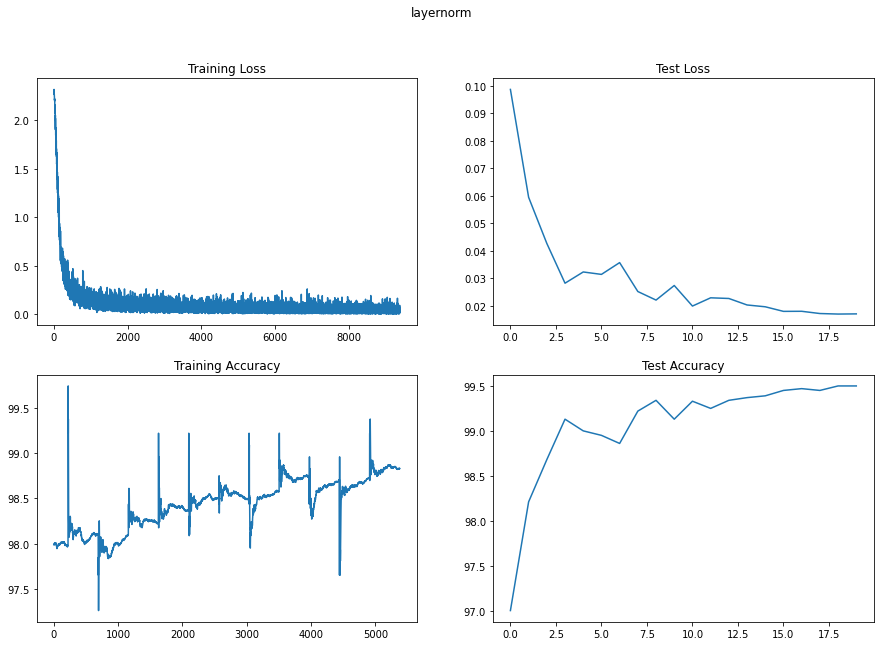

In [10]:
model, layernorm_train_losses, layernorm_test_losses, layernorm_train_acc, layernorm_test_acc = train_model("layernorm", gn=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/EVA6/Session 6 Batch Normalization and Regularization/yadl/model.py:94: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


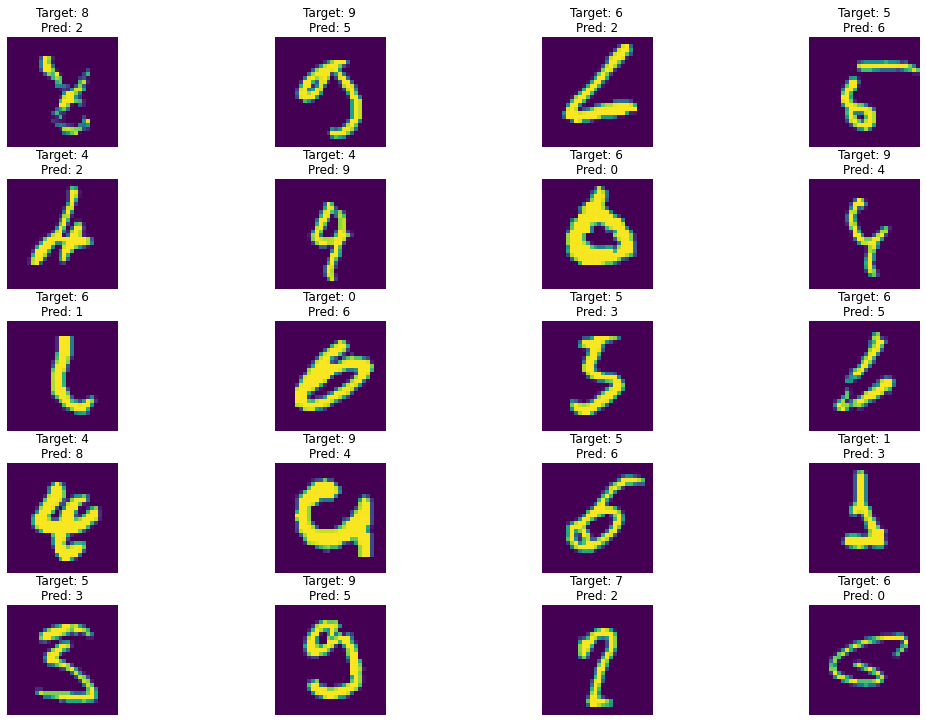

In [11]:
get_misclassified(model, "layernorm")


# 3 BatchNorm + L1

In [12]:
del model

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/EVA6/Session 6 Batch Normalization and Regularization/yadl/model.py:94: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
  0%|          | 0/469 [00:00<?, ?it/s]

*****A bit of Model Summary*****
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
         Dropout2d-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,152
              ReLU-6           [-1, 16, 28, 28]               0
       BatchNorm2d-7           [-1, 16, 28, 28]              32
         Dropout2d-8           [-1, 16, 28, 28]               0
            Conv2d-9            [-1, 8, 28, 28]             128
             ReLU-10            [-1, 8, 28, 28]               0
        MaxPool2d-11            [-1, 8, 14, 14]               0
           Conv2d-12           [-1, 12, 12, 12]             864
             ReLU-13           [-1, 12, 12, 12]               0
      

Loss=0.3119555115699768 Batch_id=468 Accuracy=77.63: 100%|██████████| 469/469 [00:16<00:00, 29.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0852, Accuracy: 9742/10000 (97.42%)

EPOCH 2 and Learning Rate [0.015652872880710073]: 


Loss=0.16729512810707092 Batch_id=468 Accuracy=94.52: 100%|██████████| 469/469 [00:16<00:00, 28.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0692, Accuracy: 9780/10000 (97.80%)

EPOCH 3 and Learning Rate [0.0420232149991973]: 


Loss=0.20174551010131836 Batch_id=468 Accuracy=95.78: 100%|██████████| 469/469 [00:15<00:00, 29.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0451, Accuracy: 9872/10000 (98.72%)

EPOCH 4 and Learning Rate [0.07804020523627854]: 


Loss=0.21363189816474915 Batch_id=468 Accuracy=96.25: 100%|██████████| 469/469 [00:16<00:00, 28.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9854/10000 (98.54%)

EPOCH 5 and Learning Rate [0.11404641502794495]: 


Loss=0.1758471429347992 Batch_id=468 Accuracy=96.68: 100%|██████████| 469/469 [00:16<00:00, 29.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9879/10000 (98.79%)

EPOCH 6 and Learning Rate [0.14038730642877603]: 


Loss=0.17659014463424683 Batch_id=468 Accuracy=96.82: 100%|██████████| 469/469 [00:16<00:00, 29.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Accuracy: 9842/10000 (98.42%)

EPOCH 7 and Learning Rate [0.14999999141525278]: 


Loss=0.14396892488002777 Batch_id=468 Accuracy=96.73: 100%|██████████| 469/469 [00:15<00:00, 29.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9886/10000 (98.86%)

EPOCH 8 and Learning Rate [0.148111607483796]: 


Loss=0.16074372828006744 Batch_id=468 Accuracy=97.14: 100%|██████████| 469/469 [00:15<00:00, 29.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Accuracy: 9886/10000 (98.86%)

EPOCH 9 and Learning Rate [0.14255711730886836]: 


Loss=0.21233083307743073 Batch_id=468 Accuracy=97.01: 100%|██████████| 469/469 [00:16<00:00, 29.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9909/10000 (99.09%)

EPOCH 10 and Learning Rate [0.1336150462213718]: 


Loss=0.2087402641773224 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:16<00:00, 29.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 9869/10000 (98.69%)

EPOCH 11 and Learning Rate [0.12173378700447057]: 


Loss=0.12389510124921799 Batch_id=468 Accuracy=97.21: 100%|██████████| 469/469 [00:16<00:00, 29.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9897/10000 (98.97%)

EPOCH 12 and Learning Rate [0.10750911560711793]: 


Loss=0.13726447522640228 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:16<00:00, 29.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Accuracy: 9882/10000 (98.82%)

EPOCH 13 and Learning Rate [0.09165431645023216]: 


Loss=0.3917433023452759 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:15<00:00, 29.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9898/10000 (98.98%)

EPOCH 14 and Learning Rate [0.07496441536741524]: 


Loss=0.1597406566143036 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:16<00:00, 28.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9902/10000 (99.02%)

EPOCH 15 and Learning Rate [0.05827631368991733]: 


Loss=0.1291440725326538 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:16<00:00, 28.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9914/10000 (99.14%)

EPOCH 16 and Learning Rate [0.04242682251929212]: 


Loss=0.1435089111328125 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:16<00:00, 29.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9919/10000 (99.19%)

EPOCH 17 and Learning Rate [0.028210701524546317]: 


Loss=0.19581234455108643 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:16<00:00, 28.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9939/10000 (99.39%)

EPOCH 18 and Learning Rate [0.01634080637370809]: 


Loss=0.13685652613639832 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:16<00:00, 29.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9938/10000 (99.38%)

EPOCH 19 and Learning Rate [0.007412343174006172]: 


Loss=0.16585832834243774 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:16<00:00, 28.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9949/10000 (99.49%)

EPOCH 20 and Learning Rate [0.0018730223522891091]: 


Loss=0.17615537345409393 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:16<00:00, 29.20it/s]



Test set: Average loss: 0.0186, Accuracy: 9951/10000 (99.51%)



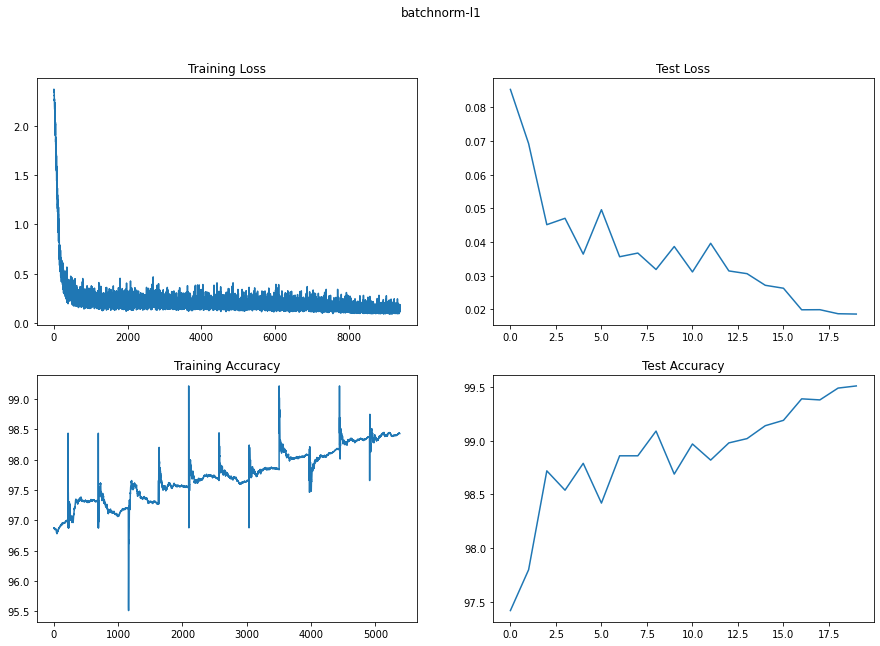

In [13]:
model, batchnorm_l1_train_losses, batchnorm_l1_test_losses, batchnorm_l1_train_acc, batchnorm_l1_test_acc = train_model("batchnorm-l1", bn=True,l1=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/EVA6/Session 6 Batch Normalization and Regularization/yadl/model.py:94: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


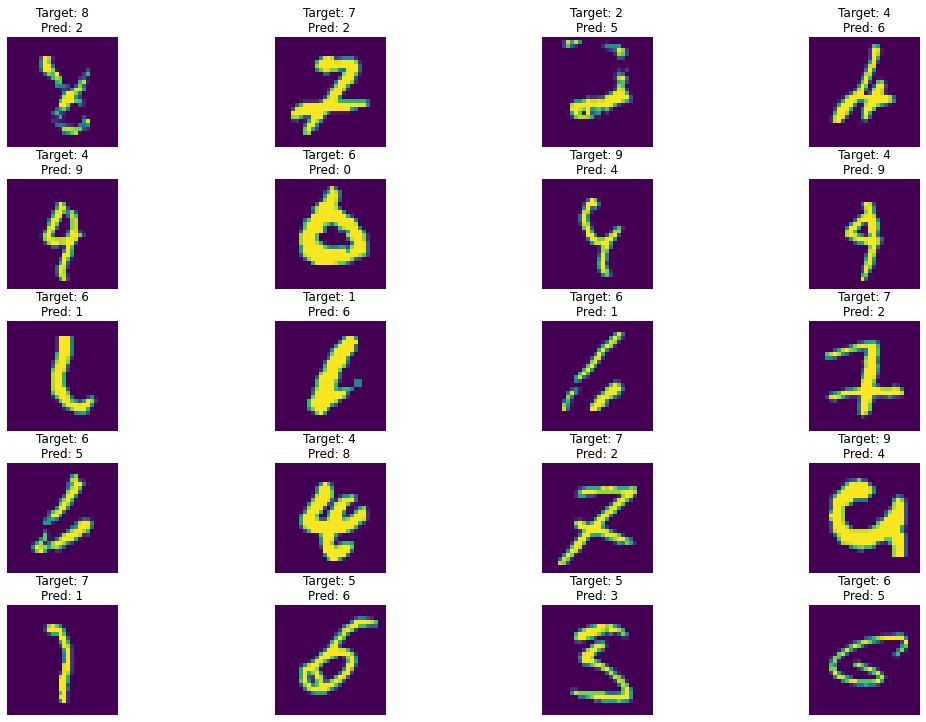

In [14]:
get_misclassified(model, "batchnorm-l1")


# Everything together

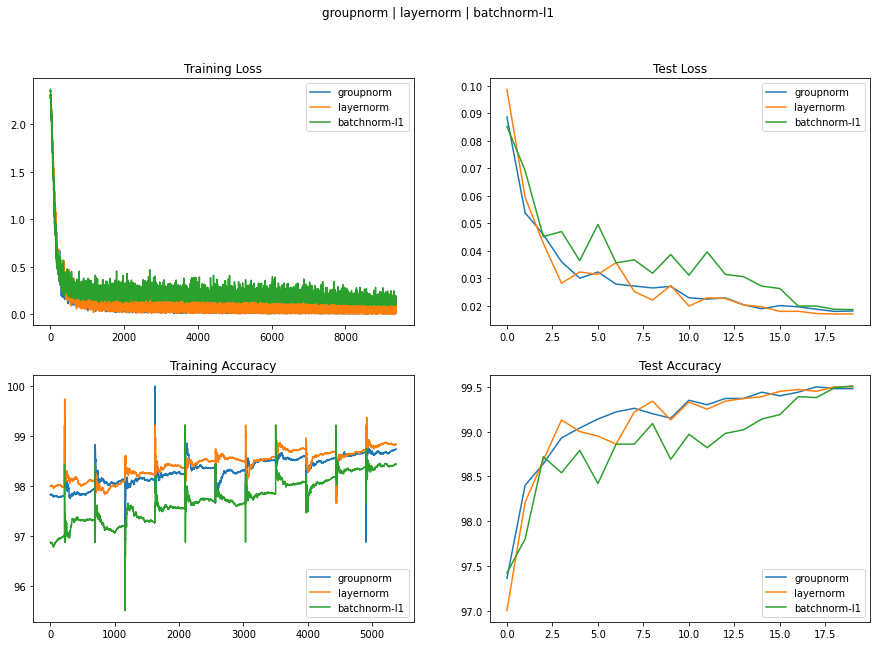

In [16]:
plot_multi(
    ["groupnorm", "layernorm", "batchnorm-l1"],
    [groupnorm_train_losses, layernorm_train_losses, batchnorm_l1_train_losses],
    [groupnorm_train_acc, layernorm_train_acc, batchnorm_l1_train_acc],
    [groupnorm_test_losses, layernorm_test_losses, batchnorm_l1_test_losses],
    [groupnorm_test_acc, layernorm_test_acc, batchnorm_l1_test_acc],
)